In [1]:
# Configs
dataset_dir = r'C:\Users\fardin\Projects\EnhanceSEO\datasets\MaliciousURL1\malicious_phish.csv'

In [2]:
# from IPython.display import clear_output
# !pip install transformers datasets torch evaluate
# clear_output()

In [38]:
import torch
import matplotlib.pyplot as plt
torch.__version__

'2.1.2+cu121'

In [48]:
rand_nums = torch.randn(5000)

In [57]:
rand_nums.shape

torch.Size([5000])

In [66]:
torch.std(rand_nums)

tensor(1.0008)

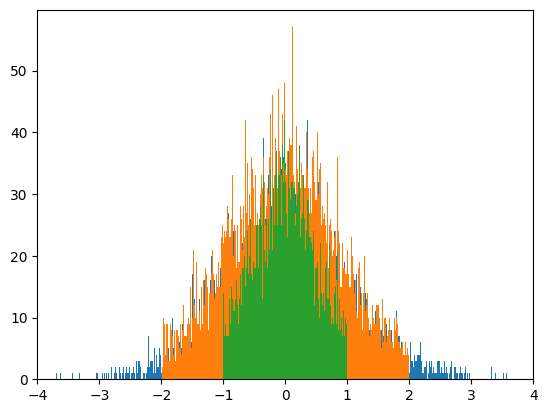

In [65]:
plt.hist(rand_nums, bins=500)
plt.hist(torch.fmod(rand_nums,2), bins=250)
plt.hist(torch.fmod(rand_nums,2.)*(2./3.), bins=250)
plt.xlim([-4, 4])
plt.show()

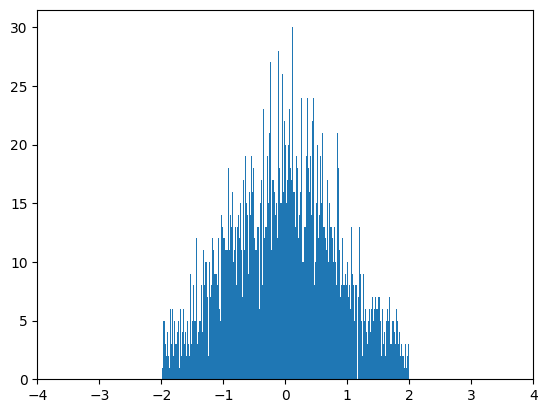

In [37]:
torch.fmod(torch.randn(5),2)

tensor([ 0.6296, -0.0765, -1.4606, -0.0199, -0.3797])

In [9]:
torch.fmod(torch.tensor([-3., -2, -1, 1, 2, 3]), 2)

tensor([-1., -0., -1.,  1.,  0.,  1.])

In [12]:
torch.tensor([-3., -2, -1, 1, 2, 3]) % 2

tensor([1., -0., 1., 1., 0., 1.])

In [8]:
a = torch.tensor([-3.])
b = 2
a.div(b, rounding_mode="trunc") * b

tensor([-2.])

In [3]:
# importing libraries 
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv(dataset_dir)
df.columns=['text', 'Topic']
df.dropna(inplace=True)
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}
df['label'] = np.array([class_id[t] for t in df['Topic']], dtype=int)
df = df.drop('Topic', axis=1)
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [5]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/586071 [00:00<?, ? examples/s]

Map:   0%|          | 0/65120 [00:00<?, ? examples/s]

In [8]:
# Set the format for PyTorch
train_dataset = train_dataset.rename_column('label', 'labels')
test_dataset = test_dataset.rename_column('label', 'labels')
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [9]:
training_args = TrainingArguments(
    output_dir=r'logs/OtherModels/bert_ag_results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=25,
    per_device_eval_batch_size=25,
    overwrite_output_dir=True,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=3,
    save_strategy="no"
)

# Load the metrics
import evaluate;
accuracy_metric = evaluate.load('accuracy', trust_remote_code=True)
precision_metric = evaluate.load('precision', trust_remote_code=True)
recall_metric = evaluate.load('recall', trust_remote_code=True)

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


Using the latest cached version of the module from C:\Users\fardin\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Sat May 18 18:36:55 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\fardin\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--precision\4e7f439a346715f68500ce6f2be82bf3272abd3f20bdafd203a2c4f85b61dd5f (last modified on Sat May 18 18:37:00 2024) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\fardin\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--recall\e40e6e98d18ff3f210f4d0b26fa721bfaa80704b1fdf890fa551cfabf94fc185 (last modified on Sat May 18 18:37:06 2024) since it couldn't be found locally

In [10]:
torch.cuda.empty_cache()
import gc
gc.collect()

72

In [11]:
# Train the model
# trainer.train(resume_from_checkpoint=r"logs/OtherModels/bert_ag_results/last_epoch")
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.049200,0.047129,0.987700,0.987093,0.977049
2,0.030800,0.039084,0.990418,0.989069,0.982915
3,0.023300,0.047980,0.990479,0.988586,0.983681
4,0.011800,0.061964,0.990264,0.988507,0.982952
5,0.004700,0.070605,0.990525,0.987776,0.983938


Evaluation results: {'eval_loss': 0.07060451805591583, 'eval_accuracy': 0.9905251842751843, 'eval_precision': 0.9877763381021575, 'eval_recall': 0.9839378848819438, 'eval_runtime': 300.514, 'eval_samples_per_second': 216.695, 'eval_steps_per_second': 8.668, 'epoch': 5.0}


In [ ]:
trainer.save_model(r"logs/OtherModels/bert_ag_results/last_epoch")

In [ ]:
Evaluation results: {'eval_loss': 0.07060451805591583, 'eval_accuracy': 0.9905251842751843, 'eval_precision': 0.9877763381021575, 'eval_recall': 0.9839378848819438, 'eval_runtime': 300.514, 'eval_samples_per_second': 216.695, 'eval_steps_per_second': 8.668, 'epoch': 5.0}


In [1]:
p = 0.9877763381021575
r = 0.9839378848819438
(2*p*r)/(p+r)

0.9858533752195847